<a href="https://colab.research.google.com/github/Jingxuan99/-Python-2-/blob/master/copy_numerical_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install POT

In [ ]:
import numpy as np
import matplotlib.pylab as pl
import ot
import ot.plot
import matplotlib.pyplot as plt
import time

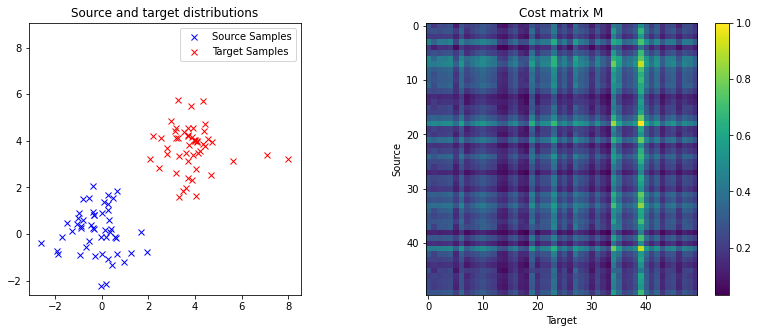

In [ ]:
# number of samples
n_s = 50 # I just found that the number of source must >= the number of target
n_t = 50
# samples weights (uniform distribution)
a, b = np.ones((n_s,))/n_s, np.ones((n_t,))/n_t 

# Draw random samples from a m-dimensional multivariate normal distribution
m = 2

# source and target
mean_s = np.zeros((m,))
cov_s = np.eye(m)  # diagonal covariance
mean_t = 4*np.ones((m,))
cov_t = np.eye(m)  # diagonal covariance
# cov_t = np.array([[1,-0.8],[-0.8,1]]) # Not identity covariance

x_s = np.random.multivariate_normal(mean_s, cov_s, n_s)
x_t = np.random.multivariate_normal(mean_t, cov_t, n_t)

f = pl.figure(2, figsize=(14,5))

# Plot points
ax = pl.subplot(1,2,1)
pl.plot(x_s[:,0], x_s[:,1], 'xb', label='Source Samples')
pl.plot(x_t[:,0], x_t[:,1], 'xr', label='Target Samples')
pl.title('Source and target distributions')
pl.axis('square')
pl.legend()

# cost matrix (squared Euclidean distances)
M = ot.dist(x_s, x_t)
M /= M.max()

# plot cost matrix
ax = pl.subplot(1,2,2)
pl.imshow(M, interpolation='nearest')
pl.xlabel('Target')
pl.ylabel('Source')
pl.title('Cost matrix M')
pl.colorbar()
pl.show()

# EMD (exact solution)
\begin{align}\begin{aligned}\gamma = \mathop{\arg \min}_\gamma \quad \langle \gamma, \mathbf{M} \rangle_F\\s.t. \ \gamma \mathbf{1} = \mathbf{a}\\     \gamma^T \mathbf{1} = \mathbf{b}\\     \gamma \geq 0\end{aligned}\end{align}

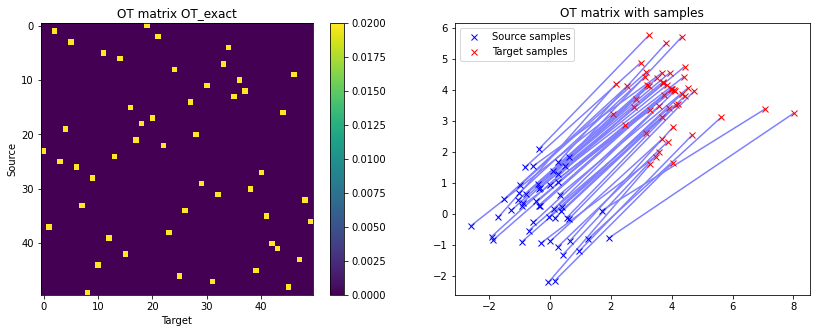

In [ ]:
# Compute EMD (Solves the Earth Movers distance problem and returns the OT matrix)
start = time.time()
OT_exact, log_emd = ot.emd(a, b, M, log = True) # exact solution
time_emd = time.time() - start

f = pl.figure(2, figsize=(14,5))

# Plot OT matrix
ax = pl.subplot(1,2,1)
pl.imshow(OT_exact, interpolation='nearest')
pl.title('OT matrix OT_exact')
pl.xlabel('Target')
pl.ylabel('Source')
pl.colorbar()

# Plot
ax = pl.subplot(1,2,2)
ot.plot.plot2D_samples_mat(x_s, x_t, OT_exact, color=[.5, .5, 1])
pl.plot(x_s[:, 0], x_s[:, 1], 'xb', label='Source samples')
pl.plot(x_t[:, 0], x_t[:, 1], 'xr', label='Target samples')
pl.legend()
pl.title('OT matrix with samples')
pl.show()
# why not fast as expected?

In [ ]:
# Wasserstein loss
print(log_emd['cost'])
print(np.sum(OT_exact*M))

0.2360167095236765
0.2360167095236766


# Sinkhorn
\begin{align}\begin{aligned}\gamma = \mathop{\arg \min}_\gamma \quad \langle \gamma, \mathbf{M} \rangle_F +
\mathrm{reg}\cdot\Omega(\gamma)\\s.t. \ \gamma \mathbf{1} &= \mathbf{a}\\     \gamma^T \mathbf{1} &= \mathbf{b}\\     \gamma &\geq 0\end{aligned}\end{align}

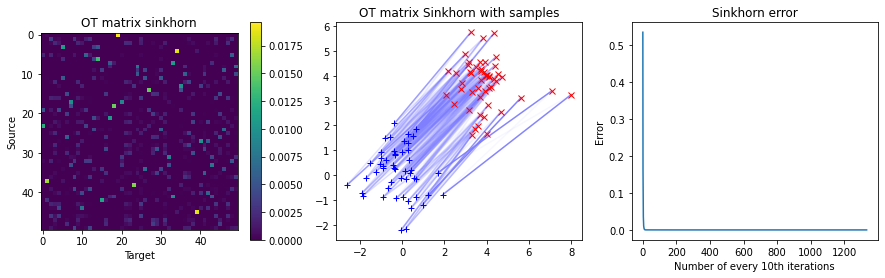

In [ ]:
# Regularized
# (Solve the entropic regularization optimal transport problem and return the OT matrix)
reg = 0.001 # reg term
numItermax = 20000

start = time.time()
OT_s, log_s = ot.sinkhorn(a, b, M, reg, numItermax=numItermax, log=True, warn=False)
time_s = time.time() - start

f = pl.figure(3, figsize=(15,4))

# Plot OT matrix (Sinkhorn)
ax = pl.subplot(1,3,1)
pl.imshow(OT_s, interpolation='nearest')
pl.title('OT matrix sinkhorn')
pl.xlabel('Target')
pl.ylabel('Source')
pl.colorbar()

# Plot
ax = pl.subplot(1,3,2)
ot.plot.plot2D_samples_mat(x_s, x_t, OT_s, color=[.5, .5, 1])
pl.plot(x_s[:, 0], x_s[:, 1], '+b', label='Source samples')
pl.plot(x_t[:, 0], x_t[:, 1], 'xr', label='Target samples')
pl.title('OT matrix Sinkhorn with samples')

# plot error
ax = pl.subplot(1,3,3)
pl.plot(log_s['err'])
pl.xlabel('Number of every 10th iterations')
pl.ylabel('Error')
pl.title('Sinkhorn error')
pl.show()

In [ ]:
# Wasserstein loss
cost_sinkhorn = np.sum(OT_s*M)
print(cost_sinkhorn)
print(f'No. of iterations is {10*len(log_s["err"])}')

0.2365388799280968
No. of iterations is 13340


# SAG(discrete case)

## meaning of some source code
(https://pythonot.github.io/gen_modules/ot.stochastic.html?highlight=coordinate_grad_semi_dual#ot.stochastic.coordinate_grad_semi_dual)

*   `ot.stochastic.solve_semi_dual_entropic`

\begin{align}\begin{aligned}\gamma = \mathop{\arg \min}_\gamma \quad \langle \gamma, \mathbf{M} \rangle_F +
\mathrm{reg} \cdot\Omega(\gamma)\\s.t. \ \gamma \mathbf{1} = \mathbf{a}\\     \gamma^T \mathbf{1} = \mathbf{b}\\     \gamma \geq 0\end{aligned}\end{align}

  *   `ot.stochastic.sag_entropic_transport` → beta
   *   `coordinate_grad_semi_dual` Compute the coordinate gradient update for regularized discrete distributions for picked number i (gradient of the semi dual problem)

\begin{align}\begin{aligned}\max_\mathbf{v} \ \sum_i \mathbf{a}_i \left[ \sum_j \mathbf{v}_j \mathbf{b}_j - \mathrm{reg}
\cdot \log \left( \sum_j \mathbf{b}_j
\exp \left( \frac{\mathbf{v}_j - \mathbf{M}_{i,j}}{\mathrm{reg}}
\right) \right) \right]\end{aligned}\end{align}

  *   `c_transform_entropic` → alpha(recover u from the c-transform.)
\begin{align}\begin{aligned}\mathbf{u} = \mathbf{v}^{c,reg} = - \mathrm{reg} \sum_j \mathbf{b}_j
\exp\left( \frac{\mathbf{v} - \mathbf{M}}{\mathrm{reg}} \right)\end{aligned}\end{align}

# Our new-defined function

In [ ]:
# Source code: https://pythonot.github.io/_modules/ot/stochastic.html#solve_semi_dual_entropic

# define a new function to get the gradient of each step
# (base on the original source code)
def my_sag_entropic_transport(a, b, M, reg, numItermax=10000, lr=None):
    if lr is None:
        lr = 1. / max(a / reg) #learning rate
    n_source = np.shape(M)[0]
    n_target = np.shape(M)[1]
    cur_beta = np.zeros(n_target)
    stored_gradient = np.zeros((n_source, n_target))
    sum_stored_gradient = np.zeros(n_target)
    grad = [] # Add this to store the gradient of each step
    for j in range(numItermax):
        i = np.random.randint(n_source)
        cur_coord_grad = a[i] * ot.stochastic.coordinate_grad_semi_dual(b, M, reg, cur_beta, i) # delta h (not H) right ????
        sum_stored_gradient += (cur_coord_grad - stored_gradient[i])
        stored_gradient[i] = cur_coord_grad
        cur_beta += lr * (1. / n_source) * sum_stored_gradient
        if j % 10 == 0:
          # checking for the error only all the 10th iterations
          # because other function in POT to get the 'err' is just record every 10 iterations
          grad.append(ot.stochastic.coordinate_grad_semi_dual(b, M, reg, cur_beta, i)) # gradients
    return cur_beta, grad

def my_solve_semi_dual_entropic(a, b, M, reg, method, numItermax=10000, lr=None, log=False):
    if method.lower() == "sag":
      # use our new defined function!!!
      opt_beta, opt_gradient = my_sag_entropic_transport(a, b, M, reg, numItermax, lr) 
    elif method.lower() == "asgd":
      opt_beta = ot.stochastic.averaged_sgd_entropic_transport(a, b, M, reg, numItermax, lr)
    else:
      print("Please, select your method between SAG and ASGD")
      return None
    
    opt_alpha = ot.stochastic.c_transform_entropic(b, M, reg, opt_beta)
    pi = (np.exp((opt_alpha[:, None] + opt_beta[None, :] - M[:, :]) / reg) *
          a[:, None] * b[None, :])

    if log:
      log = {}
      log['alpha'] = opt_alpha
      log['beta'] = opt_beta
      log['gradient'] = opt_gradient
      return pi, log
    else:
      return pi

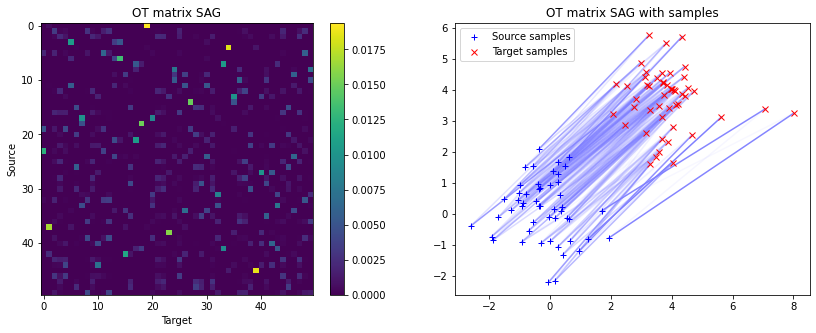

In [ ]:
# Call the “SAG” method to find the transportation matrix in the discrete case
# using our new function
start = time.time()
OT_SAG, log_SAG = my_solve_semi_dual_entropic(a, b, M, reg,
                                              numItermax = numItermax,
                                              method = "SAG",
                                              log=True)
time_SAG = time.time() - start

f = pl.figure(2, figsize=(14,5))

# Plot Transportation Matrices For SAG
ax = pl.subplot(1,2,1)
# ot.plot.plot1D_mat(a, b, OT_SAG, 'semi-dual : OT matrix SAG')
pl.imshow(OT_SAG, interpolation='nearest')
pl.title('OT matrix SAG')
pl.xlabel('Target')
pl.ylabel('Source')
pl.colorbar()

# Plot
ax = pl.subplot(1,2,2)
ot.plot.plot2D_samples_mat(x_s, x_t, OT_SAG, color=[.5, .5, 1])
pl.plot(x_s[:, 0], x_s[:, 1], '+b', label='Source samples')
pl.plot(x_t[:, 0], x_t[:, 1], 'xr', label='Target samples')
pl.legend()
pl.title('OT matrix SAG with samples')


# # plot gradient ??????????????????????????????????????
# from numpy import linalg as LA
# h_y = []
# for i in range(len(log_SAG['gradient'])):
#   h_y.append(np.log10(LA.norm(log_SAG['gradient'][i],1)))

# ax = pl.subplot(1,3,3)
# pl.title('Gradient after iterations')
# pl.xlabel('every 10th iterations')
# pl.ylabel('gradeint')
# pl.plot(h_y)
pl.show()

In [ ]:
cost_SAG = np.sum(OT_SAG*M)
print(cost_SAG)

0.23642032455644646


In [ ]:
print(round(time_emd,6), round(time_s,6), round(time_SAG,6)) # with same reg and numItermax, SAG faster

0.001142 0.593123 0.788212


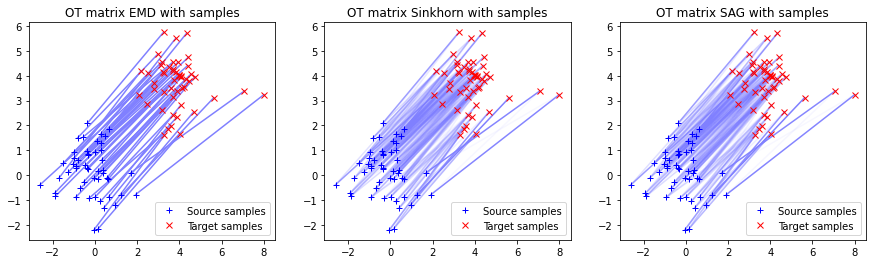

In [ ]:
# put all 3 method's transport together
# This step is just for comparing the results, so you can comment this part
f = pl.figure(3, figsize=(15,4))

ax = pl.subplot(1,3,1)
ot.plot.plot2D_samples_mat(x_s, x_t, OT_exact, color=[.5, .5, 1])
pl.plot(x_s[:, 0], x_s[:, 1], '+b', label='Source samples')
pl.plot(x_t[:, 0], x_t[:, 1], 'xr', label='Target samples')
pl.legend()
pl.title('OT matrix EMD with samples')

ax = pl.subplot(1,3,2)
ot.plot.plot2D_samples_mat(x_s, x_t, OT_s, color=[.5, .5, 1])
pl.plot(x_s[:, 0], x_s[:, 1], '+b', label='Source samples')
pl.plot(x_t[:, 0], x_t[:, 1], 'xr', label='Target samples')
pl.legend()
pl.title('OT matrix Sinkhorn with samples')

ax = pl.subplot(1,3,3)
ot.plot.plot2D_samples_mat(x_s, x_t, OT_SAG, color=[.5, .5, 1])
pl.plot(x_s[:, 0], x_s[:, 1], '+b', label='Source samples')
pl.plot(x_t[:, 0], x_t[:, 1], 'xr', label='Target samples')
pl.legend()
pl.title('OT matrix SAG with samples')

pl.show()

## Compare time

In [ ]:
equal_samples = np.linspace(50,1000,20)
computation_time = np.zeros((3,len(equal_samples)))

for i in range(len(equal_samples)):

  # Change number of samples (n_s >= n_t)
  n_s = int(equal_samples[i])
  n_t = int(equal_samples[i])

  # samples weights (uniform distribution)
  a, b = np.ones((n_s,))/n_s, np.ones((n_t,))/n_t 

  # Draw random samples from a m-dimensional multivariate normal distribution
  m = 2
  mean_s = np.zeros((m,))
  cov_s = np.eye(m)  # diagonal covariance
  mean_t = 4*np.ones((m,))
  cov_t = np.eye(m)  # diagonal covariance
  # cov_t = np.array([[1, -0.8],[-0.8,1]])

  # source and target
  x_s = np.random.multivariate_normal(mean_s, cov_s, n_s)
  x_t = np.random.multivariate_normal(mean_t, cov_t, n_t)

  # cost matrix (squared Euclidean distances)
  M = ot.dist(x_s, x_t)
  M /= M.max()

  # Compute EMD time
  start = time.time()
  matrix_EMD = ot.emd(a, b, M)
  EMD_time = time.time() - start

  reg = 0.01 # reg term
  numItermax = 200000

  # Compute Sinkhorn time
  start = time.time()
  matrix_sinkhorn = ot.sinkhorn(a, b, M, reg, numItermax=numItermax, warn=False)
  Sinkhorn_time = time.time() - start

  # Compute SAG time
  start = time.time()
  matrix_SAG = ot.stochastic.solve_semi_dual_entropic(a, b, M, reg,
                                                      numItermax = numItermax,
                                                      method = "SAG")
  SAG_time = time.time() - start

  computation_time[0,i] = EMD_time
  computation_time[1,i] = Sinkhorn_time
  computation_time[2,i] = SAG_time

KeyboardInterrupt: ignored

In [ ]:
# plot
pl.plot(equal_samples, computation_time[0,:], label = 'EMD')
pl.plot(equal_samples, computation_time[1,:], label = 'Sinkhorn')
pl.plot(equal_samples, computation_time[2,:], label = 'SAG')
pl.xlabel('Number of samples')
pl.ylabel('Time')
pl.title('Comparison of different methods with reg=0.01, numItermax = 200000')
pl.legend()
# pl.xticks(equal_samples, labels=equal_samples)
pl.show()

In [ ]:
# equal_samples = 50
# m = 2
# reg = 0.01 # reg term
# numItermax = 200000
# lr = [10, 50, 100, 200, 500, 750, 850, 1000]
# computation_time_SAG_lr = []

# n_s = equal_samples; n_t = equal_samples
# a, b = np.ones((n_s,))/n_s, np.ones((n_t,))/n_t 
# mean_s = np.zeros((m,)); cov_s = np.eye(m)
# mean_t = 4*np.ones((m,)); cov_t = np.eye(m)
# x_s = np.random.multivariate_normal(mean_s, cov_s, n_s)
# x_t = np.random.multivariate_normal(mean_t, cov_t, n_t)

# M = ot.dist(x_s, x_t)
# M /= M.max()

# for i in range(len(lr)):
#   print(f'learing rate: {lr[i]}')
#   # Compute SAG time
#   start = time.time()
#   matrix_SAG = ot.stochastic.solve_semi_dual_entropic(a, b, M, reg,
#                                                       numItermax = numItermax,
#                                                       lr = lr[i],
#                                                       method = "SAG")
#   SAG_time_lr = time.time() - start
#   computation_time_SAG_lr.append(SAG_time_lr)

In [ ]:
# # plot
# pl.plot(lr, computation_time_SAG_lr)
# pl.xlabel('Learing rate')
# pl.ylabel('Time')
# pl.title('Comparison of different learning rate of SAG')
# pl.xticks(lr, labels=lr)
# pl.show()

In [ ]:
# # Compute EMD time
# start = time.time()
# matrix_EMD = ot.emd(a, b, M)
# EMD_time = time.time() - start

# # Compute Sinkhorn time
# start = time.time()
# matrix_sinkhorn = ot.sinkhorn(a, b, M, reg, numItermax=numItermax, warn=False)
# Sinkhorn_time = time.time() - start

# # Compute SAG time
# start = time.time()
# matrix_SAG = ot.stochastic.solve_semi_dual_entropic(a, b, M, reg,
#                                                     numItermax = numItermax,
#                                                     lr = 200,
#                                                     method = "SAG")
# SAG_time = time.time() - start

In [ ]:
# print(round(EMD_time,5), round(Sinkhorn_time,5), round(SAG_time,5)) # with same reg and numItermax, SAG faster

## what we want to compare
*   time(not recommended)
*   <font color='red'>error(log=True, in the source code)</font>